In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GM
import ipinfo

In [6]:
# pinfo setup
access_token = '1333a16017c88b'
handler = ipinfo.getHandler(access_token)

In [77]:
df = pd.read_csv('ssh-logs.csv')
df.time = pd.to_datetime(df.time, format='%Y-%m-%dT%H:%M:%S', utc=True)

In [79]:
df.head()

,time,client_version,user,fingerprint,src,password
0,2017-02-08 00:30:27+00:00,SSH-2.0-sshlib-0.1,root,NaN,60.160.226.redacted,12345
1,2017-02-08 01:11:17+00:00,SSH-2.0-Go,admin,NaN,177.42.196.redacted,smcadmin
2,2017-02-08 01:56:09+00:00,SSH-2.0-sshlib-0.1,root,NaN,79.98.0.redacted,password
3,2017-02-08 20:07:33+00:00,SSH-2.0-Go,support,NaN,5.200.54.redacted,password
4,2017-02-09 04:55:19+00:00,SSH-2.0-sshlib-0.1,root,NaN,120.42.100.redacted,111111


# geocode IP addresses

In [28]:
dict_geo = {}

In [47]:
for i, src in enumerate(df.src.unique()):
    ip = src[:-len('.redacted')] + '.1'
    details = handler.getDetails(ip)
    dict_geo[src] = (details.city, details.country)
    
dict_geo

4492 190.152.105.redacted
4493 59.88.160.redacted
4494 88.147.203.redacted
4495 101.108.120.redacted
4496 188.16.111.redacted
4497 181.196.221.redacted
4498 154.126.85.redacted
4499 190.152.196.redacted
4500 49.248.87.redacted
4501 191.110.154.redacted
4502 186.130.81.redacted
4503 181.21.128.redacted
4504 190.50.158.redacted
4505 187.18.89.redacted
4506 188.17.5.redacted
4507 171.78.155.redacted
4508 186.135.152.redacted
4509 181.27.151.redacted


{'60.160.226.redacted': ('Kunming', 'CN'),
 '177.42.196.redacted': ('Salvador', 'BR'),
 '79.98.0.redacted': ('Cremona', 'IT'),
 '5.200.54.redacted': ('Saint Petersburg', 'RU'),
 '120.42.100.redacted': ('Xiamen', 'CN'),
 '105.157.52.redacted': ('Casablanca', 'MA'),
 '177.204.221.redacted': ('Pinhais', 'BR'),
 '189.243.127.redacted': ('Morelia', 'MX'),
 '184.91.189.redacted': ('Palm Bay', 'US'),
 '190.233.11.redacted': ('Lima', 'PE'),
 '93.201.188.redacted': ('Ulm', 'DE'),
 '110.84.29.redacted': ('Xiamen', 'CN'),
 '191.34.15.redacted': ('Rio de Janeiro', 'BR'),
 '117.248.40.redacted': ('Kallakurichi', 'IN'),
 '113.153.122.redacted': ('Osaka', 'JP'),
 '193.90.12.redacted': ('Vikevåg', 'NO'),
 '189.165.18.redacted': ('Puebla', 'MX'),
 '191.207.2.redacted': ('Fortaleza', 'BR'),
 '184.73.149.redacted': ('Ashburn', 'US'),
 '110.77.210.redacted': ('Nakhon Sawan', 'TH'),
 '190.6.110.redacted': ('Rafaela', 'AR'),
 '103.57.72.redacted': ('Stockholm', 'SE'),
 '179.158.101.redacted': ('Rio de Janei

In [80]:
df_geo = pd.DataFrame(dict_geo).T
df_geo.columns = ['city', 'country']
df_geo.head()

,city,country
60.160.226.redacted,Kunming,CN
177.42.196.redacted,Salvador,BR
79.98.0.redacted,Cremona,IT
5.200.54.redacted,Saint Petersburg,RU
120.42.100.redacted,Xiamen,CN


In [81]:
df = df.join(df_geo, 'src')
df.head()

,time,client_version,user,fingerprint,src,password,city,country
0,2017-02-08 00:30:27+00:00,SSH-2.0-sshlib-0.1,root,NaN,60.160.226.redacted,12345,Kunming,CN
1,2017-02-08 01:11:17+00:00,SSH-2.0-Go,admin,NaN,177.42.196.redacted,smcadmin,Salvador,BR
2,2017-02-08 01:56:09+00:00,SSH-2.0-sshlib-0.1,root,NaN,79.98.0.redacted,password,Cremona,IT
3,2017-02-08 20:07:33+00:00,SSH-2.0-Go,support,NaN,5.200.54.redacted,password,Saint Petersburg,RU
4,2017-02-09 04:55:19+00:00,SSH-2.0-sshlib-0.1,root,NaN,120.42.100.redacted,111111,Xiamen,CN


# fingerprint analysis

In [30]:
df[df.drop('fingerprint', axis=1).isna().any(axis=1)]

,time,client_version,user,fingerprint,src,password
41,2017-02-17 16:38:17-06:00,SSH-2.0-libssh-0.5.2,root,NaN,223.114.27.redacted,NaN
60,2017-02-21 06:49:30-06:00,SSH-2.0-kthrssh__x00,root,SHA256:+UJNIlXcTgv4BLeaZTgWpOCGtI+pQH//L2cG5GR...,189.135.22.redacted,NaN
1227,2017-03-17 07:37:28-05:00,SSH-2.0-OpenSSH_6.6.1,lr339r,SHA256:NdVr8EeToEpb2Whibh8vVaoJhZxy3OmcdJ0e/lx...,129.42.208.redacted,NaN
1645,2017-03-22 06:42:32-05:00,SSH-2.0-Go,root,NaN,42.116.90.redacted,NaN
1855,2017-03-24 00:22:38-05:00,SSH-2.0-Go,admin,NaN,167.205.25.redacted,NaN
2029,2017-03-26 08:13:32-05:00,SSH-2.0-Go,admin,NaN,79.200.223.redacted,NaN
3493,2017-03-28 18:23:55-05:00,SSH-2.0-Go,root,NaN,178.4.177.redacted,NaN
3564,2017-03-28 19:39:22-05:00,SSH-2.0-libssh-0.5.2,admin,NaN,190.115.139.redacted,NaN
3963,2017-03-29 01:57:54-05:00,SSH-2.0-Go,admin,NaN,14.20.113.redacted,NaN
3964,2017-03-29 01:59:05-05:00,SSH-2.0-Go,root,NaN,113.6.252.redacted,NaN


observation: if fingerprint is present then password is NaN

# calculate time differences between attacks

In [71]:
def f(group):
    group = group.sort_values('time')
    t = group.time.values.astype('datetime64[s]')
    dt = np.zeros(len(group))
    dt[1:] = pd.Series(t[1:] - t[:-1]).dt.seconds
    dt[0] = None
    return pd.Series(dt, index=group.index)

grouped = df.groupby('src').apply(f)
grouped

src                     
1.10.132.redacted   8456       NaN
1.10.158.redacted   9032       NaN
1.164.129.redacted  8530       NaN
1.171.56.redacted   4892       NaN
1.172.95.redacted   6135       NaN
                             ...  
99.14.31.redacted   2472    1218.0
                    2473     491.0
                    2476     539.0
                    2477      46.0
99.69.22.redacted   2057       NaN
Length: 10015, dtype: float64

In [82]:
dt = grouped.reset_index(level='src')[0].rename('dt')
df = df.join(dt)
df.head()

,time,client_version,user,fingerprint,src,password,city,country,dt
0,2017-02-08 00:30:27+00:00,SSH-2.0-sshlib-0.1,root,NaN,60.160.226.redacted,12345,Kunming,CN,NaN
1,2017-02-08 01:11:17+00:00,SSH-2.0-Go,admin,NaN,177.42.196.redacted,smcadmin,Salvador,BR,NaN
2,2017-02-08 01:56:09+00:00,SSH-2.0-sshlib-0.1,root,NaN,79.98.0.redacted,password,Cremona,IT,NaN
3,2017-02-08 20:07:33+00:00,SSH-2.0-Go,support,NaN,5.200.54.redacted,password,Saint Petersburg,RU,NaN
4,2017-02-09 04:55:19+00:00,SSH-2.0-sshlib-0.1,root,NaN,120.42.100.redacted,111111,Xiamen,CN,NaN


# analyze time differences

<AxesSubplot:>

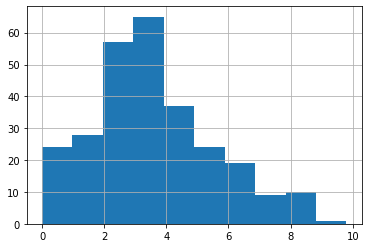

In [73]:
dt = df[df.src == '221.194.44.redacted'].dt
np.log(dt[dt>0]).hist()

In [129]:
dt = df.set_index('src', append=True).dt.dropna() #.fillna(0)

lg_dt = dt # np.log(dt + .0001)
lg_dt_agg = lg_dt.groupby('src').agg(['median', 'std', 'count']).fillna(0)
lg_dt_agg.columns = [f'dt_{col}' for col in lg_dt_agg.columns]

kmeans = KMeans(n_clusters=2).fit(lg_dt_agg)
lg_dt_agg['label'] = kmeans.labels_
lg_dt_agg

,dt_median,dt_std,dt_count,label
src,,,,
1.192.241.redacted,14.0,0.000000,1,0
1.24.230.redacted,16104.0,0.000000,1,0
1.83.54.redacted,25850.0,0.000000,1,0
101.109.152.redacted,64430.0,0.000000,1,1
101.109.36.redacted,1.5,2.121320,2,0
...,...,...,...,...
95.83.62.redacted,57592.5,26947.132324,2,1
96.231.239.redacted,1350.0,298.436481,3,0
96.80.83.redacted,242.0,2122.424086,3,0


In [151]:
lg_dt_agg.dt_count.value_counts()

1       398
2       121
3        55
4        28
5        20
7        17
6        11
8         8
11        5
14        4
9         4
12        4
10        4
13        2
15        2
34        2
16        2
24        1
157       1
280       1
213       1
28        1
243       1
64        1
94        1
1703      1
19        1
27        1
511       1
18        1
17        1
20        1
33        1
397       1
Name: dt_count, dtype: int64

Text(0, 0.5, 'std')

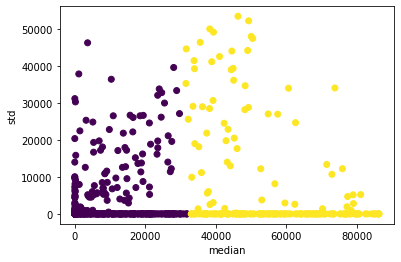

In [127]:
plt.scatter(lg_dt_agg.dt_median, lg_dt_agg.dt_std, c=lg_dt_agg.label)
plt.xlabel('median')
plt.ylabel('std')

Text(0, 0.5, 'std')

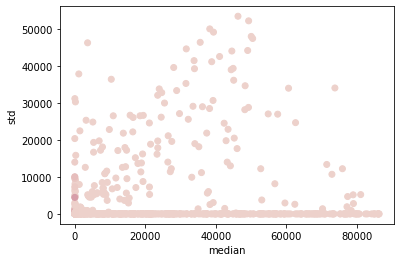

In [150]:
import seaborn as sns

cmap = sns.cubehelix_palette(as_cmap=True)

plt.scatter(lg_dt_agg.dt_median, lg_dt_agg.dt_std, c=lg_dt_agg.dt_count, cmap=cmap)
plt.xlabel('median')
plt.ylabel('std')

In [108]:
cluster = 1
df_cluster = lg_dt_agg[lg_dt_agg.label == cluster]
df_cluster = df[df.src.isin(df_cluster.index)]
df_cluster

# plt.scatter(df_cluster.dt_median, df_cluster.dt_std)
# plt.xlabel('median')
# plt.ylabel('std')

,time,client_version,user,fingerprint,src,password,city,country,dt
26,2017-02-13 23:17:08+00:00,SSH-2.0-paramiko_2.1.0,oracle,NaN,81.171.74.redacted,123,Kennington,GB,NaN
30,2017-02-14 22:21:00+00:00,SSH-2.0-paramiko_1.16.0,anonymous,NaN,81.171.74.redacted,**x0fsec**,Kennington,GB,83032.0
54,2017-02-20 15:17:01+00:00,SSH-2.0-Go,root,NaN,177.207.235.redacted,3edCft6,Brasília,BR,NaN
55,2017-02-20 15:17:06+00:00,SSH-2.0-Go,root,NaN,177.207.235.redacted,kaos,Brasília,BR,5.0
58,2017-02-21 08:49:29+00:00,SSH-2.0-Go,root,NaN,1.192.241.redacted,openelec,Zhengzhou,CN,NaN
...,...,...,...,...,...,...,...,...,...
9955,2017-08-23 20:36:07+00:00,SSH-2.0-sshlib-0.1,root,NaN,190.173.87.redacted,dreambox,Buenos Aires,AR,15906.0
9967,2017-08-24 23:44:16+00:00,SSH-2.0-sshlib-0.1,admin,NaN,186.177.213.redacted,1234,Buenos Aires,AR,67953.0
9978,2017-08-25 19:24:18+00:00,SSH-2.0-sshlib-0.1,root,NaN,190.50.240.redacted,dreambox,San Miguel,AR,20760.0
9997,2017-08-26 10:05:38+00:00,SSH-2.0-sshlib-0.1,root,NaN,31.162.128.redacted,welc0me,Yugorsk,RU,43068.0


In [123]:
dt = df.set_index('src', append=True).dt.dropna() #.fillna(0)

lg_dt = dt # np.log(dt + .0001)
lg_dt_agg = lg_dt.groupby('src').agg(['median', 'std']).fillna(0)
lg_dt_agg.columns = [f'dt_{col}' for col in lg_dt_agg.columns]

gm = GM(n_components=2).fit(lg_dt_agg)
lg_dt_agg['label'] = gm.predict(lg_dt_agg)
lg_dt_agg

,dt_median,dt_std,label
src,,,
1.192.241.redacted,14.0,0.000000,0
1.24.230.redacted,16104.0,0.000000,0
1.83.54.redacted,25850.0,0.000000,0
101.109.152.redacted,64430.0,0.000000,0
101.109.36.redacted,1.5,2.121320,1
...,...,...,...
95.83.62.redacted,57592.5,26947.132324,1
96.231.239.redacted,1350.0,298.436481,1
96.80.83.redacted,242.0,2122.424086,1


Text(0, 0.5, 'std')

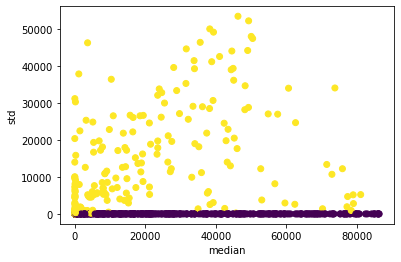

In [125]:
plt.scatter(lg_dt_agg.dt_median, lg_dt_agg.dt_std, c=lg_dt_agg.label)
plt.xlabel('median')
plt.ylabel('std')